# Detección de Idiomas - LSTM

### Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

2024-12-16 02:00:52.506559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734325252.607372    7662 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734325252.634403    7662 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 02:00:52.828499: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Cargar el dataset

In [2]:
df = pd.read_csv("dataset/updated_language_detection.csv")
df.describe()

,Text,Language
count,19821,19821
unique,19815,20
top,en cet article est partiellement ou en totalit...,Thai
freq,6,1000


### Preprocesar el Texto

- Tokenización: Convertir el texto en tokens (palabras).
- Padding: Asegurarse de que todas las secuencias de texto tengan la misma longitud.

In [3]:
# Unir todos los textos en una lista
texts = df['Text'].values

# Inicializar el Tokenizer para convertir texto en índices
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)

# Convertir los textos a secuencias de índices
X = tokenizer.texts_to_sequences(texts)

# Padding para asegurar que todas las secuencias tengan la misma longitud
X = pad_sequences(X, maxlen=100)
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  302,  250, 1300,   62,  302, 8953,
        305,  205, 5430,   62, 7741, 2157,   87, 3624, 7741, 2157,   87,
       3624], dtype=int32)

### Codificar las Etiquetas

Codificamos las etiquetas (idiomas) en valores numéricos.

In [16]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Language'])
y[:5]

array([ 3, 15, 17, 16,  1])

### Dividir el dataset en conjuntos de entrenamiento y prueba

Se utiliza stratify para mantener la proporción de clases en los conjuntos de entrenamiento y prueba.

Train: 70%

Validation: 10%

Test: 20%

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Language'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_val.shape, y_val.shape)
print("Prueba:", X_test.shape, y_test.shape)

Entrenamiento: (13874, 100) (13874,)
Validación: (1982, 100) (1982,)
Prueba: (3965, 100) (3965,)


### Construcción del Modelo LSTM

Aquí creamos la arquitectura del modelo con una capa de Embedding, seguida de una capa LSTM y capas densas para la clasificación.

In [6]:
model = Sequential()
model.add(Embedding(input_dim=50000, output_dim=100))
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.summary()

2024-12-16 02:01:03.063403: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compilar el Modelo

Ahora compilamos el modelo usando una función de pérdida adecuada (entropía cruzada) y un optimizador (Adam).

In [7]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

### Entrenar el Modelo

In [8]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10


2024-12-16 02:01:05.653152: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20000000 exceeds 10% of free system memory.
2024-12-16 02:01:05.723699: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20000000 exceeds 10% of free system memory.
2024-12-16 02:01:05.741382: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20000000 exceeds 10% of free system memory.
2024-12-16 02:01:05.789672: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20000000 exceeds 10% of free system memory.
2024-12-16 02:01:05.807430: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20000000 exceeds 10% of free system memory.


217/217 ━━━━━━━━━━━━━━━━━━━━ 37s 151ms/step - accuracy: 0.4732 - loss: 2.0222 - val_accuracy: 0.9768 - val_loss: 0.0984
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.9832 - loss: 0.0824 - val_accuracy: 0.9844 - val_loss: 0.0667
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - accuracy: 0.9910 - loss: 0.0415 - val_accuracy: 0.9874 - val_loss: 0.0566
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 31s 142ms/step - accuracy: 0.9939 - loss: 0.0287 - val_accuracy: 0.9899 - val_loss: 0.0479
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 33s 152ms/step - accuracy: 0.9966 - loss: 0.0179 - val_accuracy: 0.9884 - val_loss: 0.0522
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 44s 165ms/step - accuracy: 0.9961 - loss: 0.0203 - val_accuracy: 0.9884 - val_loss: 0.0514
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 31s 145ms/step - accuracy: 0.9969 - loss: 0.0149 - val_accuracy: 0.9874 - val_loss: 0.0558
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - accuracy: 0.9976 - loss: 0.0135 - val

### Evaluación del Modelo

In [9]:
score, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Accuracy: {accuracy * 100:.2f}%')

124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9879 - loss: 0.0554
Accuracy: 98.84%


### Guardar el modelo

In [10]:
model.save("models/lstm_model.keras")

#### Precciones no acertadas

In [27]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
language_names = label_encoder.classes_
decoded_texts = tokenizer.sequences_to_texts(X_test)

for i in range(len(y_test)):
    if y_pred[i] != y_test[i]:
        predicted_language = language_names[y_pred[i]]
        real_language = language_names[y_test[i]]

        print(f"Texto: {decoded_texts[i]}")
        print(f"Predicción: {predicted_language} (Real: {real_language})\n")

124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Texto: سيد علي محمد سيد علي يا علي البلاد
Predicción: Turkish (Real: Arabic)

Texto: standard bank tang city agung kota era white place city group mall mall blok a tanah blok b tanah park spring hill
Predicción: English (Real: Indonesian)

Texto: iv
Predicción: Thai (Real: Estonian)

Texto: farrington d p b e da de grupo de comportamento
Predicción: Dutch (Real: Portugese)

Texto: 
Predicción: Thai (Real: Estonian)

Texto: × tipe mm in tetap dan × tipe mm in
Predicción: English (Real: Indonesian)

Texto: new
Predicción: Thai (Real: Estonian)

Texto: france e e série de et de sociales de recherche
Predicción: Latin (Real: French)

Texto: la de no p
Predicción: Spanish (Real: French)

Texto: de voleibol confederação sul americana de voleibol
Predicción: Portugese (Real: Thai)

Texto: monte da cruz ca lista de de la en julio de
Predicción: Dutch (Real: Spanish)

Texto: د ممکن
Predicción: Thai (Real: Pushto)

Texto: ülikooli
Predicción: Thai (Real:

In [18]:
language_names = label_encoder.classes_
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=language_names))


Classification Report:
               precision    recall  f1-score   support

      Arabic       1.00      0.99      1.00       199
       Dutch       0.98      0.99      0.99       199
     English       0.99      0.99      0.99       200
    Estonian       0.98      0.96      0.97       200
      French       0.98      0.98      0.98       198
       Hindi       1.00      1.00      1.00       197
  Indonesian       0.99      0.98      0.99       194
      Korean       1.00      0.99      0.99       200
       Latin       0.97      0.98      0.97       190
     Persian       0.99      0.99      0.99       200
   Portugese       0.99      0.98      0.99       199
      Pushto       0.99      0.99      0.99       197
    Romanian       0.99      0.99      0.99       200
     Russian       1.00      0.99      0.99       200
     Spanish       0.99      0.98      0.98       199
     Swedish       1.00      0.99      1.00       197
       Tamil       1.00      0.99      0.99       196
  

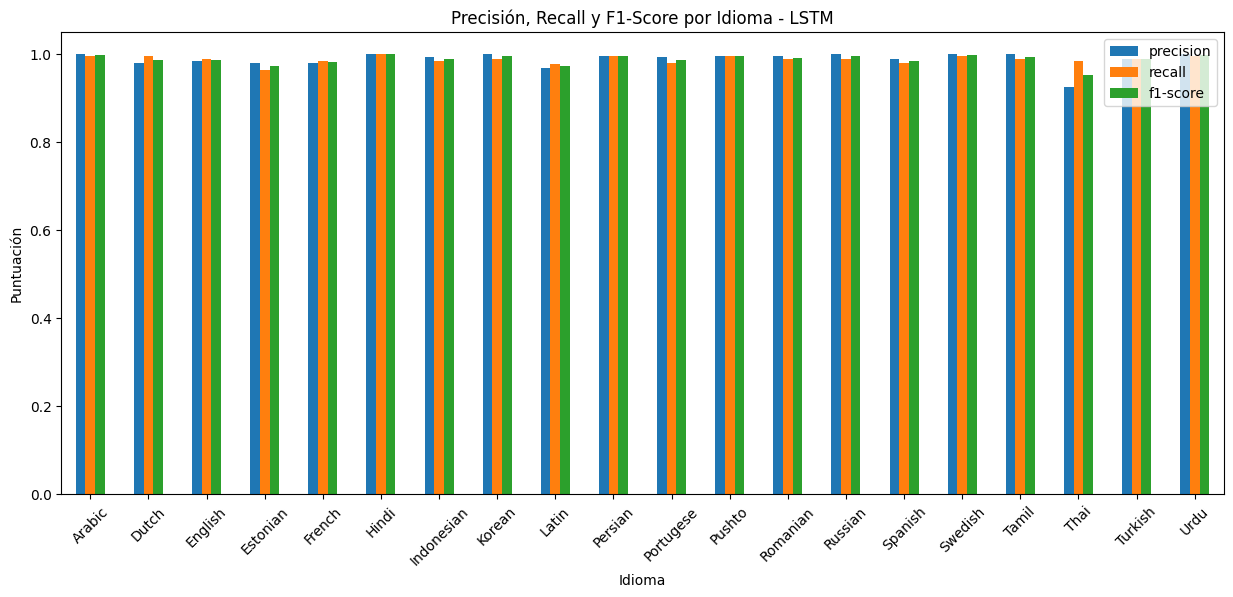

In [17]:
report_dict = classification_report(y_test, y_pred, target_names=language_names, output_dict=True)
report_df = pd.DataFrame(report_dict).T[:-3]

report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(15, 6))
plt.title("Precisión, Recall y F1-Score por Idioma - LSTM")
plt.ylabel("Puntuación")
plt.xlabel("Idioma")
plt.xticks(rotation=45)
plt.savefig("plots/lstm_precision_recall_f1.png")
plt.show()

In [19]:
def preprocess_text(texts, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    return padded_sequences

input_text = ["hola este es un texto en español", "hello this is a text in english", "bonjour ceci est un texte en français", "ola isto é um texto em português"]
preprocessed_text = preprocess_text(input_text, tokenizer)

prediction = model.predict(preprocessed_text)
y_prediction = np.argmax(prediction, axis=1)

for i in range(len(input_text)):
    predicted_language = language_names[y_prediction[i]]
    print(f"Texto: {input_text[i]}")
    print(f"Predicción: {predicted_language}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Texto: hola este es un texto en español
Predicción: Spanish

Texto: hello this is a text in english
Predicción: English

Texto: bonjour ceci est un texte en français
Predicción: French

Texto: ola isto é um texto em português
Predicción: Portugese



#### Matriz de Confusión

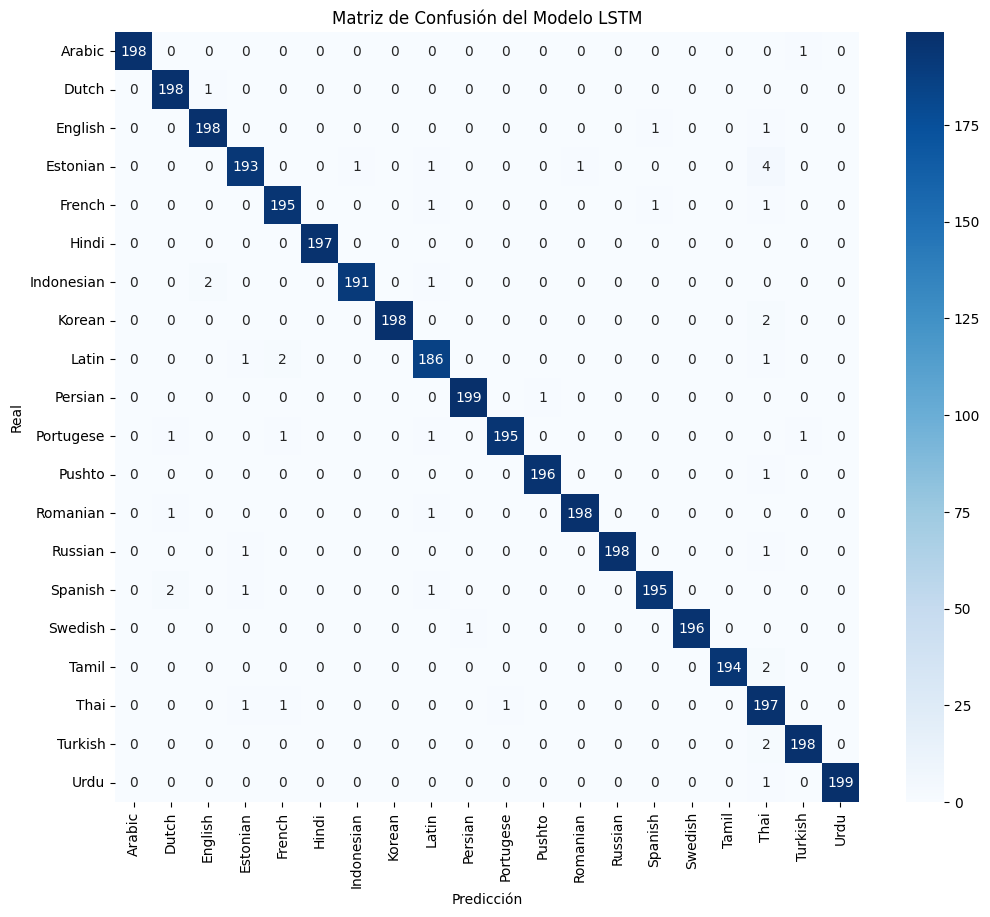

In [20]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=language_names, yticklabels=language_names)
plt.title("Matriz de Confusión del Modelo LSTM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.savefig("plots/lstm_confusion_matrix.png")
plt.show()

### Matriz de Confusión Normalizada

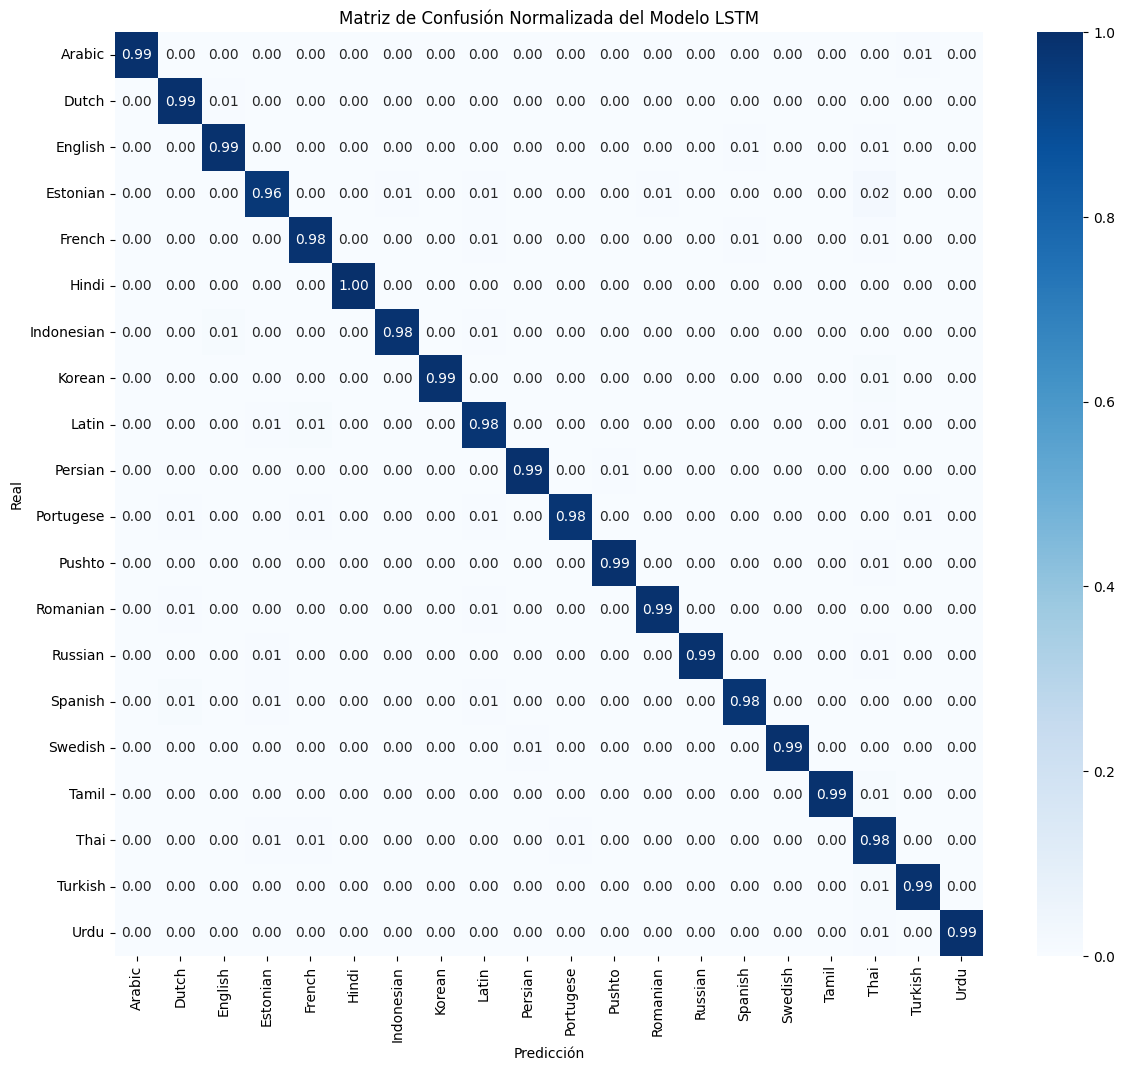

In [21]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=language_names, yticklabels=language_names)
plt.title("Matriz de Confusión Normalizada del Modelo LSTM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.savefig("plots/lstm_confusion_matrix_normalized.png")
plt.show()

### Accuracy en Train y Validation

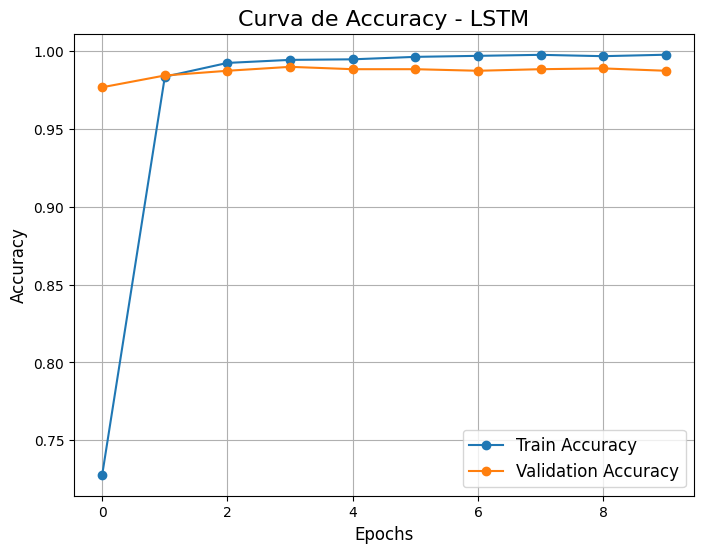

In [24]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Curva de Accuracy - LSTM', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("plots/lstm_accuracy_curve.png")
plt.show()

### Loss en Train y Validation

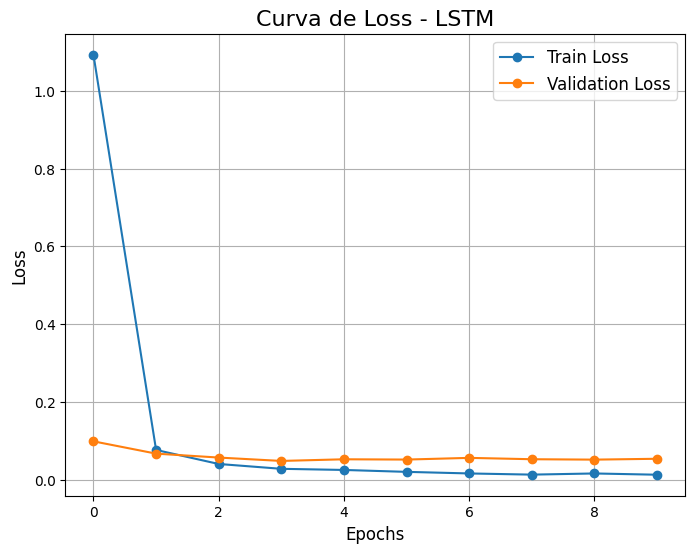

In [25]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Curva de Loss - LSTM', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("plots/lstm_loss_curve.png")
plt.show()